In [87]:
import visa 
import numpy as np
import serial
import time
import os
import math
import h5py
from utils import *
from pathlib import Path
path = os.getcwd()
path = Path(path)
print(Path(str(path.parent) + '\\Classes\\') )

import sys
sys.path.append(str(path.parent) + '\\Classes\\')
from SMA100B import *
from vna import *
from SIM928 import *

%load_ext autoreload
%autoreload 2

C:\Users\oper\Desktop\labparamp\QTLab2122\TWPA\Classes
C:\Users\oper\Desktop\labparamp\QTLab2122\TWPA\Classes
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
%matplotlib notebook

In [74]:
field_fox = vna('192.168.3.3')
field_fox.query('*IDN?')

'Keysight Technologies,N9916A,MY53104702,A.08.01\n'

In [75]:
pump = SMA100B('192.168.3.2')
pump.query('*IDN?')

'Rohde&Schwarz,SMA100B,1419.8888K02/105168,4.70.205.75  \n'

In [76]:
bias = SIM928('COM28', '4')
bias.query('*IDN?')

'Stanford_Research_Systems,SIM928,s/n030465,ver2.2\r\n'

In [78]:
#pump power
p0 = -18.5 #-45
p1 = -17.5 #-15 #best: 19
dp = 0.10 #2
P = np.arange(p0, p1, dp)
N_p = P.size
print(N_p)

#pump frequency
f0 = 17.75 #16.5
f1 = 18.25 #17.5
df = 50e-5
F = np.arange(f0, f1, df)
N_f = F.size
print(N_f)

#bias voltageat SIM
v0 = 0.300
v1 = 0.340
dv = 0.002
V = np.arange(v0, v1, dv)
N_v = V.size
print(N_v)

f, d = field_fox.print_data()
n_points = f.size

filename = 'scan_banda_completa.hdf5'
#storage_hdf5(filename, f, 'band_freq')
#storage_hdf5(filename, F, 'pump_freq')
#storage_hdf5(filename, P, 'pump_pow')
#storage_hdf5(filename, V, 'bias_voltage')
#print(n_points)

spectra = np.empty((N_f, N_v, N_p, n_points))

10
1000
21


In [79]:
start_time = time.time()
for i in range(0, N_v):
    bias.set_voltage(V[i])
    for j in range(0, N_p):
        pump.set_ampl(P[j])
        for k in range(0, N_f):
            pump.set_freq(F[k]*1e9)
            f, d = field_fox.print_data()
            spectra[k,i,j,:] = d
final_time = time.time() - start_time
#storage_hdf5(filename, spectra, 'spectra')


In [80]:
final_time/3600

85.57178775959545

In [88]:
f, d_off = field_fox.print_data()
storage_hdf5(filename, d_off, 'd_off')

In [90]:
real_spectra = spectra - d_off #d_off is the spectral density corresponding to no bias voltage
bw_tensor = np.empty((N_f, N_v, N_p))
gain_tensor = np.empty((N_f, N_v, N_p))

for i in range(0, N_v):
    for j in range(0, N_p):
        for k in range(0, N_f):
            bw_tensor[k,i,j], i1, i2 = band_width_info(f, spectra[k,i,j,:])
            gain_tensor[k,i,j] = np.mean(real_spectra[k,i,j,i1:i2])



0.34 18.24399999999885 -17.79999999999999
4728750000.0 5.141433766871135
24312554925.091877


<IPython.core.display.Javascript object>


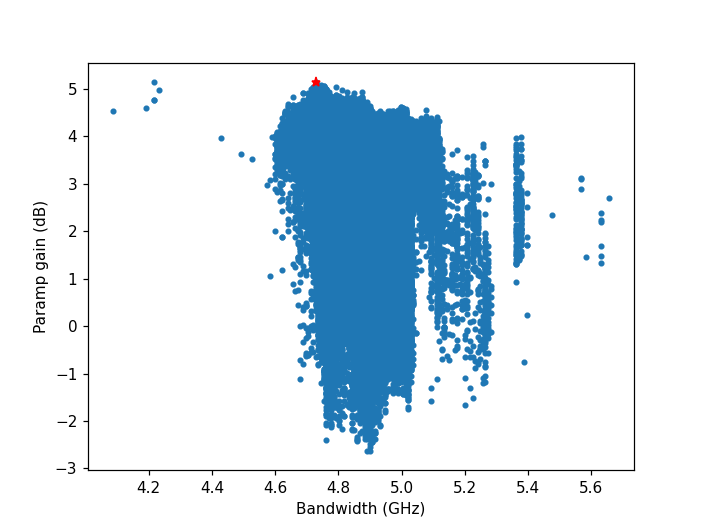

In [166]:
prod_tensor = gain_tensor * bw_tensor
prod_best = prod_tensor.max()
k_best, i_best, j_best = np.where(prod_tensor == prod_best)
gain_best = gain_tensor[k_best, i_best, j_best][0]
bw_best = bw_tensor[k_best, i_best, j_best][0]
pump_freq_best = F[k_best][0]
pump_pow_best = P[j_best][0]
volt_best = V[i_best][0]

print(volt_best, pump_freq_best, pump_pow_best)
print(bw_best, gain_best)
print(prod_best)


plt.scatter(bw_tensor/1e9, gain_tensor, marker='.')
plt.plot(bw_best/1e9, gain_best, '*r')
plt.xlabel('Bandwidth (GHz)')
plt.ylabel('Paramp gain (dB)')
plt.savefig('scatter_gain_bw.png')

<IPython.core.display.Javascript object>


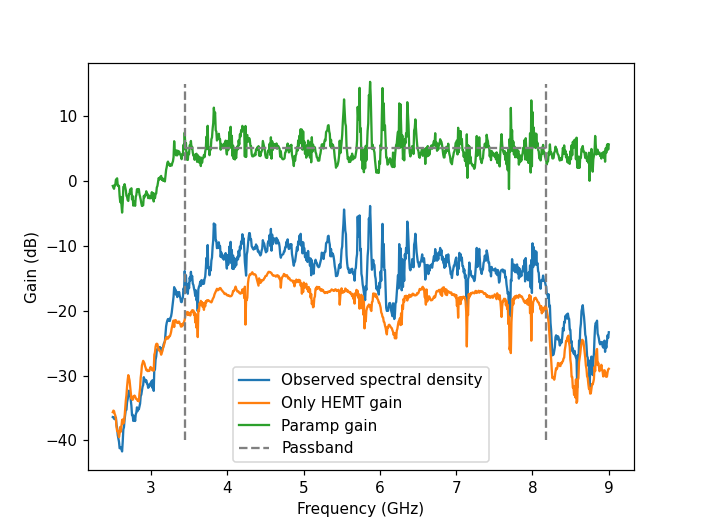

converged at 3th iteration!
4728750000.0
5.141433766871135 2.1099672346191336 3.4425


In [167]:
plt.plot(f/1e9, np.squeeze(spectra[k_best, i_best, j_best, :]))
g, bw, start = band_info(f, np.squeeze(spectra[k_best, i_best, j_best, :]))
plt.plot(f/1e9, d_off)
print(bw)

plt.plot(f/1e9, np.squeeze(real_spectra[k_best, i_best, j_best, :]))
b, i1, i2 = band_width_info(f, np.squeeze((spectra[k_best, i_best, j_best,:])))
real_g = np.mean(real_spectra[k_best, i_best, j_best,i1:i2])
n = np.std(real_spectra[k_best, i_best, j_best,i1:i2])

plt.vlines(start/1e9, -40, 15, linestyles ="dashed", colors ="0.5")
plt.vlines((start+bw)/1e9, -40, 15, linestyles ="dashed", colors ="0.5")
plt.hlines(real_g, start/1e9, (start+bw)/1e9, linestyles ="dashed", colors ="0.5")
#plt.hlines(g, start/1e9, (start+bw)/1e9, linestyles ="dashed", colors ="0.5")



plt.legend(['Observed spectral density', 'Only HEMT gain','Paramp gain', 'Passband'], loc='best')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Gain (dB)')

print(real_g, n, f[i1]/1e9)
plt.savefig('final_results.png')